In [1]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()
    
def sigmoid(x):
    "Stabilna funkcja sigmoidalna"""
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
sigmoid = np.vectorize(sigmoid)

def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))
sigmoid_der = np.vectorize(sigmoid_der)

def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def prepear_data(df_train, df_test):
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    #Implementacja wymaga "pionowego" wektora cech
    x_train.shape = (len(x_train), 1)
    x_test.shape = (len(x_test), 1)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train, y_train, x_test, y_test

In [3]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 #Parametry rozkładu jednostajnego dla losowych wag
                 lb = -1,
                 ub = 1,
                 #Możliwe do ustawienia wagi i bias-y
                 weights = None, 
                 biases = None):
        
        #Domyślne losowo wygenerowane wagi i bias-y jeśli nie zostały podane
        d_weights = random.uniform(lb, ub, size = (output_size, input_size))
        d_biases = random.uniform(lb, ub, size = (output_size, 1))
        
        #Wagi dla wszystkich neuronów z warstwy 
        self.weights = weights if weights is not None else d_weights
        
        #Stałe "b"
        self.biases = biases if biases is not None else d_biases
        
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(self.weights@input + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return self.weights@input + self.biases

In [36]:
class Network:
    
    def __init__(self, layers: list):
        
        #Warstwy
        self.layers = layers
        self.momentum_w = [np.zeros(l.weights.shape) for l in layers]
        self.momentum_b = [np.zeros(l.biases.shape) for l in layers]
        self.g_w = [np.zeros(l.weights.shape) for l in layers]
        self.g_b = [np.zeros(l.biases.shape) for l in layers]
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = []
        delta_weights = []
        
        n_layers = len(self.layers)
        err = [None]*n_layers
        #Wyliczenie err ostatniej warstwy
        err[-1] = (Y - activations[-1])*self.layers[-1].activation_fun_der(sums[-1])
        
        #Wyliczenie gradientu MSE po parametrach ostatniej warstwy
        #delta_biases[-1] = err
        #delta_weights[-1] = activations[-2].transpose()@err
        
        #Propagacja wsteczna
        for i in range(n_layers-2, -1, -1):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err[i] = (self.layers[i+1].weights.transpose()@err[i+1]) * act_f_der 
            
        #Batch size
        batch_size = Y.shape[1]
        delta_biases = [e@np.ones((batch_size, 1))/float(batch_size) 
                              for e in err]
        delta_weights = [np.dot(e, activations[i].transpose())/float(batch_size) 
                        for i, e in enumerate(err)]
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, 
              batch_size = 1, 
              etha = 0.001, 
              tol = 10**(-6), 
              n_iter = 500, 
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        """Wytrenowuje sieć wybraną metodą minimalizując MSE 
        na zbiorze walidacyjnym
        return: liczba epok (na potrzeby porównań)"""
        if(batch_size==1):
            algorithm = self.gd
        else:
            algorithm = self.batch_gd
            
        
        #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
        #w zmiennych objaśnających i zmiennej celu
        X = np.copy(x_train)
        Y = np.copy(y_train)
        random.RandomState(42).shuffle(X)
        random.RandomState(42).shuffle(Y)

        #Podział zbioru na część walidacyjną i treningową
        #proporcje: val 20% - train 80%
        X_split = np.split(X, [int(.8 * X.shape[1])], axis=1)
        X_train, X_val = X_split[0], X_split[1]

        Y_split = np.split(Y, [int(.8 * Y.shape[1])], axis=1)
        Y_train, Y_val = Y_split[0], Y_split[1]
        
        #Właściwe trenowanie sieci
        current_mse = np.inf
        new_mse = MSE(self.predict(X_val), Y_val)
        it = 1
        while True:
            #Wywołanie konkretnego algorytmu
            algorithm(X_train, Y_train, batch_size, etha, l_m, beta)
            new_mse = MSE(self.predict(X_val), Y_val)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                print("Current MSE on validation set:")
                print(new_mse)
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            if(it == n_iter):
                break
            elif(current_mse - new_mse > tol):
                current_mse = new_mse
            else:
                break
            
        return it
    
    def gd(self, X, Y, etha, l_m, beta):
        """Trening sieci podstawową metodą Gradient Descent"""
        b, w = self.backprop(X, Y)
        for i in range(len(self.layers)):
            #Aktualizacja momentum
            self.momentum_w[i] = w[i]+l_m*self.momentum_w[i]
            self.momentum_b[i] = b[i]+l_m*self.momentum_b[i]
            
            #Aktualizacja RMSProp
            self.g_w[i] = (1-beta)*w[i]*w[i]+beta*self.g_w[i]
            self.g_b[i] = (1-beta)*b[i]*b[i]+beta*self.g_b[i]
        
            l = self.layers[i]
            l.biases = l.biases + etha*self.momentum_b[i] - (etha*b[i])/np.sqrt(0.0001+self.g_b[i]) 
            l.weights = l.weights + etha*self.momentum_w[i] - (etha*w[i])/np.sqrt(0.0001+self.g_w[i])
            
        return
    
    def batch_gd(self, X, Y, batch_size, etha, l_m, beta):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wywołanie metody gradient descent na kolejnych batch-ach
        i=0
        while(i<len(Y)):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            self.gd(x, y, etha, l_m, beta)
        return
        

In [5]:
df1_train = pd.read_csv("./mio1/regression/square-simple-training.csv")
df1_test = pd.read_csv("./mio1/regression/square-simple-test.csv")

In [6]:
x_train, y_train, x_test, y_test = prepear_data(df1_train, df1_test)

In [7]:
x_train = x_train.reshape(1, -1)
y_train = y_train.reshape(1,-1)
x_test = x_test.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [33]:
l1_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
l1_2 = Layer(input_size=5, output_size=1, lb = -1, ub = 1, 
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)        
nn = Network([l1_1, l1_2])

In [34]:
nn.train(x_train, y_train, l_m = 0.2, beta = 0.1, tol=10**(-20), n_iter=500, batch_size=20, etha=0.001, verbose=True)

Epoche 1 finished
Current MSE on validation set:
6.417203079798685
Warstwa 0 wagi:
[[ 0.81091433]
 [ 0.22780037]
 [-0.70748989]
 [-0.48657333]
 [ 0.28553872]]
Warstwa 0 bias-y:
[[ 0.60183474]
 [-0.13493428]
 [ 0.89471357]
 [ 0.3034454 ]
 [ 0.7641734 ]]
Warstwa 1 wagi:
[[-0.36365254 -0.49810875 -0.6921718  -0.0984164  -0.69105244]]
Warstwa 1 bias-y:
[[-0.70671537]]


Epoche 2 finished
Current MSE on validation set:
6.396562547293871
Warstwa 0 wagi:
[[ 0.81181066]
 [ 0.22861126]
 [-0.70674144]
 [-0.48565386]
 [ 0.2863288 ]]
Warstwa 0 bias-y:
[[ 0.60262769]
 [-0.13430091]
 [ 0.89524076]
 [ 0.30436372]
 [ 0.76475657]]
Warstwa 1 wagi:
[[-0.3624727  -0.49763504 -0.69130429 -0.09789172 -0.68993041]]
Warstwa 1 bias-y:
[[-0.70473722]]


Epoche 3 finished
Current MSE on validation set:
6.3743724147465795
Warstwa 0 wagi:
[[ 0.81269938]
 [ 0.22941153]
 [-0.70600547]
 [-0.48474034]
 [ 0.28710784]]
Warstwa 0 bias-y:
[[ 0.60340993]
 [-0.13368371]
 [ 0.89574872]
 [ 0.3052751 ]
 [ 0.76532244]]
Warstwa 

Epoche 29 finished
Current MSE on validation set:
5.822618481096917
Warstwa 0 wagi:
[[ 0.83594775]
 [ 0.25035229]
 [-0.68664519]
 [-0.46118757]
 [ 0.30759785]]
Warstwa 0 bias-y:
[[ 0.62411128]
 [-0.11735278]
 [ 0.9094064 ]
 [ 0.32905103]
 [ 0.78051889]]
Warstwa 1 wagi:
[[-0.32928358 -0.48378505 -0.66671857 -0.08255543 -0.65837126]]
Warstwa 1 bias-y:
[[-0.6499272]]


Epoche 30 finished
Current MSE on validation set:
5.8026927007769284
Warstwa 0 wagi:
[[ 0.83684822]
 [ 0.25116471]
 [-0.68588968]
 [-0.46029036]
 [ 0.30839681]]
Warstwa 0 bias-y:
[[ 0.62492294]
 [-0.11671067]
 [ 0.90995271]
 [ 0.32996882]
 [ 0.7811251 ]]
Warstwa 1 wagi:
[[-0.32809922 -0.48329833 -0.66584634 -0.08201185 -0.65724737]]
Warstwa 1 bias-y:
[[-0.64797183]]


Epoche 31 finished
Current MSE on validation set:
5.782858538259876
Warstwa 0 wagi:
[[ 0.83774912]
 [ 0.25197763]
 [-0.68513339]
 [-0.45939395]
 [ 0.30919654]]
Warstwa 0 bias-y:
[[ 0.62573568]
 [-0.11606756]
 [ 0.91050052]
 [ 0.33088678]
 [ 0.78173286]]
Warstw

Epoche 61 finished
Current MSE on validation set:
5.228187792671184
Warstwa 0 wagi:
[[ 0.86495125]
 [ 0.27658669]
 [-0.66210052]
 [-0.432973  ]
 [ 0.33352981]]
Warstwa 0 bias-y:
[[ 0.65059013]
 [-0.09633082]
 [ 0.92759966]
 [ 0.35845229]
 [ 0.80064929]]
Warstwa 1 wagi:
[[-0.29291824 -0.46910514 -0.6401093  -0.06600828 -0.6239368 ]]
Warstwa 1 bias-y:
[[-0.58989445]]


Epoche 62 finished
Current MSE on validation set:
5.2109726354560815
Warstwa 0 wagi:
[[ 0.86586307]
 [ 0.27741404]
 [-0.6613218 ]
 [-0.43211182]
 [ 0.33435172]]
Warstwa 0 bias-y:
[[ 0.65143334]
 [-0.09565881]
 [ 0.9281908 ]
 [ 0.35937012]
 [ 0.80130154]]
Warstwa 1 wagi:
[[-0.29183137 -0.46867522 -0.63931966 -0.0655187  -0.62291002]]
Warstwa 1 bias-y:
[[-0.58810035]]


Epoche 63 finished
Current MSE on validation set:
5.193835290524436
Warstwa 0 wagi:
[[ 0.86677516]
 [ 0.27824183]
 [-0.66054241]
 [-0.43125216]
 [ 0.3351743 ]]
Warstwa 0 bias-y:
[[ 0.65227744]
 [-0.09498592]
 [ 0.92878324]
 [ 0.36028774]
 [ 0.80195512]]
Warst

Epoche 98 finished
Current MSE on validation set:
4.640167962842766
Warstwa 0 wagi:
[[ 0.89883585]
 [ 0.30747334]
 [-0.63286028]
 [-0.40237994]
 [ 0.36435713]]
Warstwa 0 bias-y:
[[ 0.68233717]
 [-0.07091387]
 [ 0.95029884]
 [ 0.392137  ]
 [ 0.82562409]]
Warstwa 1 wagi:
[[-0.25458135 -0.45428243 -0.61246804 -0.0489525  -0.58780525]]
Warstwa 1 bias-y:
[[-0.52660923]]


Epoche 99 finished
Current MSE on validation set:
4.62558931165618
Warstwa 0 wagi:
[[ 0.89975466]
 [ 0.30831555]
 [-0.63205843]
 [-0.40159775]
 [ 0.36520148]]
Warstwa 0 bias-y:
[[ 0.68320957]
 [-0.07021196]
 [ 0.95093472]
 [ 0.39303462]
 [ 0.82632179]]
Warstwa 1 wagi:
[[-0.25359701 -0.45391162 -0.61176425 -0.04852105 -0.58687988]]
Warstwa 1 bias-y:
[[-0.5249841]]


Epoche 100 finished
Current MSE on validation set:
4.6110754832110645
Warstwa 0 wagi:
[[ 0.90067357]
 [ 0.30915812]
 [-0.63125601]
 [-0.40081842]
 [ 0.36604639]]
Warstwa 0 bias-y:
[[ 0.68408267]
 [-0.0695093 ]
 [ 0.95157173]
 [ 0.39393124]
 [ 0.8270206 ]]
Warstw

Epoche 129 finished
Current MSE on validation set:
4.217019662951721
Warstwa 0 wagi:
[[ 0.9273347 ]
 [ 0.33374658]
 [-0.60774591]
 [-0.37967059]
 [ 0.39077656]]
Warstwa 0 bias-y:
[[ 0.70967948]
 [-0.04882094]
 [ 0.97050967]
 [ 0.41933622]
 [ 0.84775331]]
Warstwa 1 wagi:
[[-0.22525857 -0.44346836 -0.59163867 -0.03627511 -0.56029034]]
Warstwa 1 bias-y:
[[-0.47818646]]


Epoche 130 finished
Current MSE on validation set:
4.20431270468363
Warstwa 0 wagi:
[[ 0.92825355]
 [ 0.33459953]
 [-0.6069273 ]
 [-0.37899882]
 [ 0.39163678]]
Warstwa 0 bias-y:
[[ 0.71057092]
 [-0.04809726]
 [ 0.97117806]
 [ 0.42018508]
 [ 0.8484836 ]]
Warstwa 1 wagi:
[[-0.22435256 -0.44314222 -0.5909997  -0.03588986 -0.55944188]]
Warstwa 1 bias-y:
[[-0.47668978]]


Epoche 131 finished
Current MSE on validation set:
4.191661659183778
Warstwa 0 wagi:
[[ 0.9291723 ]
 [ 0.3354528 ]
 [-0.60610819]
 [-0.37833139]
 [ 0.39249747]]
Warstwa 0 bias-y:
[[ 0.71146289]
 [-0.04737292]
 [ 0.97184743]
 [ 0.42103162]
 [ 0.84921486]]
Wars

Epoche 157 finished
Current MSE on validation set:
3.8815339576811616
Warstwa 0 wagi:
[[ 0.95300109]
 [ 0.35774701]
 [-0.58464095]
 [-0.36265386]
 [ 0.41503309]]
Warstwa 0 bias-y:
[[ 0.73482617]
 [-0.02831785]
 [ 0.98958238]
 [ 0.44200783]
 [ 0.86855653]]
Warstwa 1 wagi:
[[-0.20078352 -0.43484172 -0.57448035 -0.02603915 -0.53740633]]
Warstwa 1 bias-y:
[[-0.43773859]]


Epoche 158 finished
Current MSE on validation set:
3.8702985802119776
Warstwa 0 wagi:
[[ 0.95391437]
 [ 0.35860851]
 [-0.58380899]
 [-0.36212091]
 [ 0.41590562]]
Warstwa 0 bias-y:
[[ 0.73573076]
 [-0.02757673]
 [ 0.99027676]
 [ 0.44276534]
 [ 0.86931256]]
Warstwa 1 wagi:
[[-0.19994283 -0.43455245 -0.57389488 -0.02569464 -0.53662162]]
Warstwa 1 bias-y:
[[-0.4363485]]


Epoche 159 finished
Current MSE on validation set:
3.85911234650933
Warstwa 0 wagi:
[[ 0.95482734]
 [ 0.3594703 ]
 [-0.58297658]
 [-0.36159352]
 [ 0.41677855]]
Warstwa 0 bias-y:
[[ 0.73663575]
 [-0.02683502]
 [ 0.99097202]
 [ 0.44351841]
 [ 0.87006946]]
War

Epoche 188 finished
Current MSE on validation set:
3.555132016645904
Warstwa 0 wagi:
[[ 0.9811262 ]
 [ 0.38458153]
 [-0.55864994]
 [-0.3488446 ]
 [ 0.4422608 ]]
Warstwa 0 bias-y:
[[ 0.76303121]
 [-0.00508006]
 [ 1.01149924]
 [ 0.46297353]
 [ 0.89237671]]
Warstwa 1 wagi:
[[-0.17573811 -0.4264424  -0.55715532 -0.01603694 -0.51406678]]
Warstwa 1 bias-y:
[[-0.39629645]]


Epoche 189 finished
Current MSE on validation set:
3.5453225843495275
Warstwa 0 wagi:
[[ 0.98202544]
 [ 0.38545137]
 [-0.55780492]
 [-0.34849571]
 [ 0.44314494]]
Warstwa 0 bias-y:
[[ 0.7639458 ]
 [-0.00432176]
 [ 1.01221914]
 [ 0.46354591]
 [ 0.89315768]]
Warstwa 1 wagi:
[[-0.17496418 -0.42619037 -0.55662393 -0.01573775 -0.51334681]]
Warstwa 1 bias-y:
[[-0.39501471]]


Epoche 190 finished
Current MSE on validation set:
3.5355559897796107
Warstwa 0 wagi:
[[ 0.98292406]
 [ 0.38632147]
 [-0.55695952]
 [-0.34815296]
 [ 0.44402943]]
Warstwa 0 bias-y:
[[ 0.76486063]
 [-0.00356295]
 [ 1.01293982]
 [ 0.46411063]
 [ 0.8939394 ]]
W

Epoche 219 finished
Current MSE on validation set:
3.270155443843376
Warstwa 0 wagi:
[[ 1.0086633 ]
 [ 0.41165866]
 [-0.53227898]
 [-0.3408474 ]
 [ 0.46981953]]
Warstwa 0 bias-y:
[[0.79146865]
 [0.01865969]
 [1.03416131]
 [0.47677167]
 [0.9169198 ]]
Warstwa 1 wagi:
[[-0.15267963 -0.41914363 -0.54143043 -0.00745934 -0.49264705]]
Warstwa 1 bias-y:
[[-0.3580689]]


Epoche 220 finished
Current MSE on validation set:
3.261591917648037
Warstwa 0 wagi:
[[ 1.00953784]
 [ 0.4125358 ]
 [-0.53142252]
 [-0.34068358]
 [ 0.47071338]]
Warstwa 0 bias-y:
[[0.79238793]
 [0.01943318]
 [1.03490374]
 [0.47707022]
 [0.91772245]]
Warstwa 1 wagi:
[[-0.15196701 -0.41892529 -0.54094809 -0.00720696 -0.49198608]]
Warstwa 1 bias-y:
[[-0.35688602]]


Epoche 221 finished
Current MSE on validation set:
3.2530658950368876
Warstwa 0 wagi:
[[ 1.01041137]
 [ 0.41341317]
 [-0.53056572]
 [-0.34052536]
 [ 0.47160752]]
Warstwa 0 bias-y:
[[0.79330726]
 [0.02020713]
 [1.03564685]
 [0.47735919]
 [0.91852574]]
Warstwa 1 wagi:
[[

Epoche 242 finished
Current MSE on validation set:
3.082404493320291
Warstwa 0 wagi:
[[ 1.02849645]
 [ 0.43188681]
 [-0.51249589]
 [-0.33843456]
 [ 0.49044675]]
Warstwa 0 bias-y:
[[0.81261285]
 [0.03656321]
 [1.05140482]
 [0.48123528]
 [0.93553976]]
Warstwa 1 wagi:
[[-0.13675857 -0.41437608 -0.53070788 -0.00204797 -0.47789342]]
Warstwa 1 bias-y:
[[-0.33161504]]


Epoche 243 finished
Current MSE on validation set:
3.0746640694951926
Warstwa 0 wagi:
[[ 1.029344  ]
 [ 0.43276876]
 [-0.51163187]
 [-0.33839037]
 [ 0.49134668]]
Warstwa 0 bias-y:
[[0.81353153]
 [0.03734684]
 [1.05216226]
 [0.48131831]
 [0.93635661]]
Warstwa 1 wagi:
[[-0.13608812 -0.41418055 -0.53025885 -0.00183149 -0.47727274]]
Warstwa 1 bias-y:
[[-0.33049974]]


Epoche 244 finished
Current MSE on validation set:
3.066957607498561
Warstwa 0 wagi:
[[ 1.0301902 ]
 [ 0.43365092]
 [-0.51076754]
 [-0.33835089]
 [ 0.49224686]]
Warstwa 0 bias-y:
[[0.81445009]
 [0.03813089]
 [1.05292031]
 [0.48139252]
 [0.93717405]]
Warstwa 1 wagi:
[

Epoche 275 finished
Current MSE on validation set:
2.844111404255696
Warstwa 0 wagi:
[[ 1.05565096]
 [ 0.46109163]
 [-0.48382567]
 [-0.33922492]
 [ 0.52026407]]
Warstwa 0 bias-y:
[[0.84281868]
 [0.06263662]
 [1.0767154 ]
 [0.4797584 ]
 [0.96279057]]
Warstwa 1 wagi:
[[-0.11554265 -0.40840723 -0.51659975  0.00426021 -0.4582725 ]]
Warstwa 1 bias-y:
[[-0.29625831]]


Epoche 276 finished
Current MSE on validation set:
2.8374158105746217
Warstwa 0 wagi:
[[ 1.05644421]
 [ 0.4619797 ]
 [-0.48295203]
 [-0.33931298]
 [ 0.52117118]]
Warstwa 0 bias-y:
[[0.84372864]
 [0.06343331]
 [1.07749211]
 [0.47959451]
 [0.96362538]]
Warstwa 1 wagi:
[[-0.11492811 -0.40824132 -0.51619424  0.00442447 -0.4577047 ]]
Warstwa 1 bias-y:
[[-0.29523194]]


Epoche 277 finished
Current MSE on validation set:
2.830749513786893
Warstwa 0 wagi:
[[ 1.0572355 ]
 [ 0.46286794]
 [-0.48207813]
 [-0.3394043 ]
 [ 0.52207847]]
Warstwa 0 bias-y:
[[0.84463817]
 [0.06423038]
 [1.07826936]
 [0.47942469]
 [0.96446068]]
Warstwa 1 wagi:
[

Epoche 310 finished
Current MSE on validation set:
2.626344132343406
Warstwa 0 wagi:
[[ 1.08212162]
 [ 0.49227153]
 [-0.45309504]
 [-0.34397916]
 [ 0.5521161 ]]
Warstwa 0 bias-y:
[[0.8743221 ]
 [0.09073276]
 [1.1042119 ]
 [0.47106028]
 [0.9922931 ]]
Warstwa 1 wagi:
[[-0.09496422 -0.4030817  -0.50311837  0.00908168 -0.43927041]]
Warstwa 1 bias-y:
[[-0.26180379]]


Epoche 311 finished
Current MSE on validation set:
2.620597215954846
Warstwa 0 wagi:
[[ 1.08283473]
 [ 0.49316518]
 [-0.45221261]
 [-0.3441574 ]
 [ 0.55302897]]
Warstwa 0 bias-y:
[[0.87520876]
 [0.09154164]
 [1.10500653]
 [0.47073898]
 [0.99314418]]
Warstwa 1 wagi:
[[-0.09440352 -0.40294347 -0.50275385  0.00919178 -0.43875284]]
Warstwa 1 bias-y:
[[-0.26086217]]


Epoche 312 finished
Current MSE on validation set:
2.6148751844241707
Warstwa 0 wagi:
[[ 1.0835452 ]
 [ 0.49405898]
 [-0.45132995]
 [-0.34433755]
 [ 0.55394198]]
Warstwa 0 bias-y:
[[0.87609448]
 [0.09235084]
 [1.10580163]
 [0.47041453]
 [0.99399569]]
Warstwa 1 wagi:
[

Epoche 342 finished
Current MSE on validation set:
2.454221872200681
Warstwa 0 wagi:
[[ 1.10354379]
 [ 0.52093831]
 [-0.4247473 ]
 [-0.35046473]
 [ 0.58138956]]
Warstwa 0 bias-y:
[[0.90213259]
 [0.11677242]
 [1.12986805]
 [0.45951406]
 [1.01973031]]
Warstwa 1 wagi:
[[-0.0777276  -0.39900953 -0.49197887  0.01187069 -0.42335647]]
Warstwa 1 bias-y:
[[-0.23277043]]


Epoche 343 finished
Current MSE on validation set:
2.4492155686306742
Warstwa 0 wagi:
[[ 1.10416375]
 [ 0.52183637]
 [-0.42385794]
 [-0.35068798]
 [ 0.58230615]]
Warstwa 0 bias-y:
[[0.90297924]
 [0.11759113]
 [1.13067709]
 [0.45912073]
 [1.02059413]]
Warstwa 1 wagi:
[[-0.07721177 -0.39889347 -0.49164758  0.01193396 -0.42287997]]
Warstwa 1 bias-y:
[[-0.23189845]]


Epoche 344 finished
Current MSE on validation set:
2.444230643687672
Warstwa 0 wagi:
[[ 1.10478053]
 [ 0.52273455]
 [-0.42296838]
 [-0.35091216]
 [ 0.58322285]]
Warstwa 0 bias-y:
[[0.90382425]
 [0.11841014]
 [1.13148656]
 [0.45872599]
 [1.02145833]]
Warstwa 1 wagi:
[

Epoche 378 finished
Current MSE on validation set:
2.286767461912328
Warstwa 0 wagi:
[[ 1.12377181]
 [ 0.55334479]
 [-0.3926101 ]
 [-0.35889672]
 [ 0.61443652]]
Warstwa 0 bias-y:
[[0.93139126]
 [0.14642145]
 [1.15924943]
 [0.44475659]
 [1.05104803]]
Warstwa 1 wagi:
[[-0.05997899 -0.39522119 -0.48064275  0.01328445 -0.40693857]]
Warstwa 1 bias-y:
[[-0.20263294]]


Epoche 379 finished
Current MSE on validation set:
2.2824702853289653
Warstwa 0 wagi:
[[ 1.12427001]
 [ 0.5542471 ]
 [-0.39171406]
 [-0.35913714]
 [ 0.61535565]]
Warstwa 0 bias-y:
[[0.93216146]
 [0.14724996]
 [1.16007277]
 [0.44433751]
 [1.05192407]]
Warstwa 1 wagi:
[[-0.05950937 -0.39512684 -0.48034444  0.01329914 -0.40650327]]
Warstwa 1 bias-y:
[[-0.20183122]]


Epoche 380 finished
Current MSE on validation set:
2.2781911327659743
Warstwa 0 wagi:
[[ 1.12476467]
 [ 0.55514952]
 [-0.39081784]
 [-0.3593776 ]
 [ 0.61627482]]
Warstwa 0 bias-y:
[[0.93292896]
 [0.14807874]
 [1.16089648]
 [0.44391837]
 [1.05280042]]
Warstwa 1 wagi:


Epoche 410 finished
Current MSE on validation set:
2.15779235656408
Warstwa 0 wagi:
[[ 1.13793861]
 [ 0.58227032]
 [-0.36385601]
 [-0.3665093 ]
 [ 0.64386496]]
Warstwa 0 bias-y:
[[0.95451066]
 [0.17305631]
 [1.18577378]
 [0.43147706]
 [1.07922804]]
Warstwa 1 wagi:
[[-0.04554534 -0.39246659 -0.47150532  0.01313781 -0.39352391]]
Warstwa 1 bias-y:
[[-0.17786105]]


Epoche 411 finished
Current MSE on validation set:
2.1540319751038144
Warstwa 0 wagi:
[[ 1.13832198]
 [ 0.58317587]
 [-0.36295489]
 [-0.36674101]
 [ 0.64478492]]
Warstwa 0 bias-y:
[[0.95517568]
 [0.17389258]
 [1.18660835]
 [0.43107179]
 [1.0801133 ]]
Warstwa 1 wagi:
[[-0.04511358 -0.39238891 -0.47123282  0.01311338 -0.39312121]]
Warstwa 1 bias-y:
[[-0.17711533]]


Epoche 412 finished
Current MSE on validation set:
2.150287110348947
Warstwa 0 wagi:
[[ 1.13870175]
 [ 0.58408153]
 [-0.36205363]
 [-0.36697211]
 [ 0.64570488]]
Warstwa 0 bias-y:
[[0.95583678]
 [0.17472907]
 [1.18744325]
 [0.43066745]
 [1.08099882]]
Warstwa 1 wagi:
[[

Epoche 442 finished
Current MSE on validation set:
2.044813408051273
Warstwa 0 wagi:
[[ 1.14844558]
 [ 0.61129281]
 [-0.33495114]
 [-0.37354224]
 [ 0.67329973]]
Warstwa 0 bias-y:
[[0.97365621]
 [0.1999267 ]
 [1.21263854]
 [0.41910949]
 [1.1076815 ]]
Warstwa 1 wagi:
[[-0.03228338 -0.39021006 -0.46314647  0.01180102 -0.38109883]]
Warstwa 1 bias-y:
[[-0.15479475]]


Epoche 443 finished
Current MSE on validation set:
2.0415157410515676
Warstwa 0 wagi:
[[ 1.14871633]
 [ 0.61220118]
 [-0.33404568]
 [-0.37374631]
 [ 0.67421922]]
Warstwa 0 bias-y:
[[0.97417699]
 [0.20076993]
 [1.21348315]
 [0.41874801]
 [1.10857462]]
Warstwa 1 wagi:
[[-0.03188699 -0.3901468  -0.46289679  0.01174148 -0.38072532]]
Warstwa 1 bias-y:
[[-0.15409955]]


Epoche 444 finished
Current MSE on validation set:
2.0382314699323816
Warstwa 0 wagi:
[[ 1.14898368]
 [ 0.61310963]
 [-0.3331401 ]
 [-0.37394925]
 [ 0.67513867]]
Warstwa 0 bias-y:
[[0.97469268]
 [0.20161337]
 [1.21432805]
 [0.41838837]
 [1.10946796]]
Warstwa 1 wagi:


Epoche 474 finished
Current MSE on validation set:
1.9456420971229007
Warstwa 0 wagi:
[[ 1.15546334]
 [ 0.64039905]
 [-0.30591772]
 [-0.37943097]
 [ 0.70269955]]
Warstwa 0 bias-y:
[[0.98766041]
 [0.22700935]
 [1.23980776]
 [0.40859441]
 [1.13636724]]
Warstwa 1 wagi:
[[-0.02012035 -0.38838293 -0.45547493  0.0094041  -0.36955917]]
Warstwa 1 bias-y:
[[-0.13326748]]


Epoche 475 finished
Current MSE on validation set:
1.9427444628645418
Warstwa 0 wagi:
[[ 1.15562961]
 [ 0.64130984]
 [-0.30500858]
 [-0.37959103]
 [ 0.70361729]]
Warstwa 0 bias-y:
[[0.98800553]
 [0.22785887]
 [1.24066135]
 [0.40830582]
 [1.137267  ]]
Warstwa 1 wagi:
[[-0.01975727 -0.38833205 -0.45524535  0.00931356 -0.36921177]]
Warstwa 1 bias-y:
[[-0.13261787]]


Epoche 476 finished
Current MSE on validation set:
1.9398584270919041
Warstwa 0 wagi:
[[ 1.1557928 ]
 [ 0.6422207 ]
 [-0.30409933]
 [-0.37974947]
 [ 0.70453495]]
Warstwa 0 bias-y:
[[0.98834484]
 [0.22870859]
 [1.24151521]
 [0.40801998]
 [1.13816695]]
Warstwa 1 wagi:

500

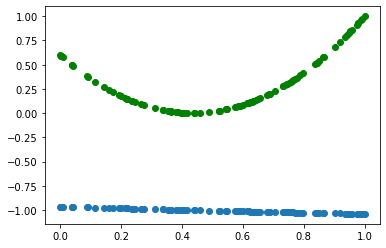

In [35]:
plt.scatter(x_train, nn.predict(x_train))
plt.scatter(x_train, y_train, color="green")